### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
import numpy as np

### Configurações

In [2]:
pd.set_option('display.max_columns', 500)

# Predição de bons pagadores (Crédito)

##### **Contexto**:
Uma empresa de cartões de crédito disponibilizou uma base de dados, contendo informações demográficas e financiais, de seus clientes. Cada linha representa uma conta bancária.

##### **Objetivo**:
Criar um modelo capaz de captar a inadimplência dos clientes no próximo mês.

## Iniciando o projeto*

*_OBS:_* _Uma boa prática ao se iniciar um projeto em dados, é separar o dataset para que não ocorra vazamento de dados (data leakage). Essa abordagem não foi utilizada pelo autor. Sendo assim, não será realizada a separação nesta etapa do projeto._

### Exploração dos dados

In [3]:
df = pd.read_excel('data/default_of_credit_card_clients__courseware_version_1_21_19.xls')

In [4]:
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  int64 
 3   EDUCATION                   30000 non-null  int64 
 4   MARRIAGE                    30000 non-null  int64 
 5   AGE                         30000 non-null  int64 
 6   PAY_1                       30000 non-null  object
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

##### 1. How many columns are there in the data?
##### 2. How many rows (samples)?

In [6]:
colunas = ''

for coluna in df.columns:
    colunas += coluna + ', '
    
print(f'Esse conjunto de dados possui {df.shape[0]} observações e {df.shape[1]} variáveis. Sendo elas:\n\n{colunas}')

Esse conjunto de dados possui 30000 observações e 25 variáveis. Sendo elas:

ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_1, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, default payment next month, 


##### 3. What kind of features are there? Which are categorical and which are numerical?

In [7]:
colunas_numericas = [column for column in df.columns if df[column].dtype == 'int64']
colunas_categoricas = [column for column in df.columns if df[column].dtype == 'object']

print(f'Das colunas presentes, {len(colunas_numericas)} são numéricas e {len(colunas_categoricas)} são categóricas')

Das colunas presentes, 23 são numéricas e 2 são categóricas


##### 4. What does the data look like in these features?

##### Podemos encontrar um pequeno problema. A coluna "**PAY_1**" está sendo classificada como categórica, porém, seus dados são numéricos.

In [8]:
df[colunas_categoricas].head()

,ID,PAY_1
0,798fc410-45c1,2
1,8a8c8f3b-8eb4,-1
2,85698822-43f5,0
3,0737c11b-be42,0
4,3b7f77cc-dbc0,-1


##### Dicionário criado para facilitar a identificação das variáveis durante o projeto.

In [9]:
info_var = {
    "LIMIT_BAL": "Amount of the credit provided (in New Taiwanese (NT) dollar) including individual consumer credit and the family (supplementary) credit.",
    "SEX": "Gender (1 = male; 2 = female).",
    "EDUCATION": "Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).",
    "MARRIAGE": "Marital status (1 = married; 2 = single; 3 = others).",
    "AGE": "Age (year).",
    "PAY_1": "A record of past payments. Represents the repayment status in September. (-2 = the account started that month with a zero balance, and never used any credit; 0 = At least the minimum payment was made, but the entire balance wasn't paid; -1 = pay duly; 1 = payment delay for one month and so on..)",
    "PAY_2": "A record of past payments. Represents the repayment status in August. (-2 = the account started that month with a zero balance, and never used any credit; 0 = At least the minimum payment was made, but the entire balance wasn't paid; -1 = pay duly; 1 = payment delay for one month and so on..)",
    "PAY_3": "A record of past payments. Represents the repayment status in July. (-2 = the account started that month with a zero balance, and never used any credit; 0 = At least the minimum payment was made, but the entire balance wasn't paid; -1 = pay duly; 1 = payment delay for one month and so on..)",
    "PAY_4": "A record of past payments. Represents the repayment status in June. (-2 = the account started that month with a zero balance, and never used any credit; 0 = At least the minimum payment was made, but the entire balance wasn't paid; -1 = pay duly; 1 = payment delay for one month and so on..)",
    "PAY_5": "A record of past payments. Represents the repayment status in May. (-2 = the account started that month with a zero balance, and never used any credit; 0 = At least the minimum payment was made, but the entire balance wasn't paid; -1 = pay duly; 1 = payment delay for one month and so on..)",
    "PAY_6": "A record of past payments. Represents the repayment status in April. (-2 = the account started that month with a zero balance, and never used any credit; 0 = At least the minimum payment was made, but the entire balance wasn't paid; -1 = pay duly; 1 = payment delay for one month and so on..)",
    "BILL_AMT1": "Represents the bill statement (in NT dollar) amount in September",
    "BILL_AMT2": "Represents the bill statement (in NT dollar) amount in August",
    "BILL_AMT3": "Represents the bill statement (in NT dollar) amount in July",
    "BILL_AMT4": "Represents the bill statement (in NT dollar) amount in June",
    "BILL_AMT5": "Represents the bill statement (in NT dollar) amount in May",
    "BILL_AMT6": "Represents the bill statement (in NT dollar) amount in April",
    "PAY_AMT1" : "Amount of previous payment (NT dollar). Represents the amount paid in September",
    "PAY_AMT2" : "Amount of previous payment (NT dollar). Represents the amount paid in August",
    "PAY_AMT3" : "Amount of previous payment (NT dollar). Represents the amount paid in July",
    "PAY_AMT4" : "Amount of previous payment (NT dollar). Represents the amount paid in June",
    "PAY_AMT5" : "Amount of previous payment (NT dollar). Represents the amount paid in May",
    "PAY_AMT6" : "Amount of previous payment (NT dollar). Represents the amount paid in April"
}

##### Validando se os números de ID's não estão repetidos.

In [10]:
df["ID"].nunique()

29687

In [11]:
df["ID"].value_counts().value_counts()

count
1    29374
2      313
Name: count, dtype: int64

###### Existem 313 casos de ID's repetidos.

In [12]:
duplicados = df[df.duplicated('ID', keep=False)].sort_values(by='ID', ascending=False)

duplicados.head(6)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
8746,ffb9a143-c375,80000,1,1,2,27,0,0,0,0,0,0,42653,46609,47306,51179,52073,52833,5000,1801,5000,2035,2100,6200,0
8846,ffb9a143-c375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2105,ffa0f012-3bd7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2005,ffa0f012-3bd7,20000,1,2,2,34,Not available,-2,-2,-2,-2,-2,2199,1530,750,2280,1500,780,1530,750,1140,3000,780,0,0
20226,ff8b7170-ce3a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20126,ff8b7170-ce3a,50000,2,3,1,48,-1,-1,2,-1,-1,0,2896,1360,812,4012,28672,28875,1500,500,4100,28800,1011,1041,0


In [13]:
dupe_ids = list(duplicados["ID"].unique())

##### Remoção dos ID's repetidos*

*_OBS:_* _Ao remover dados antes do treinamento, pode acarretar em vazamento de dados (data leakage). Essa abordagem foi utilizada pelo autor, seguirei dessa forma durante este projeto._

In [14]:
df_zero_mask = df == 0
feature_zero_mask = df_zero_mask.iloc[:, 1:].all(axis=1)

In [15]:
df_clean = df.loc[~feature_zero_mask].copy()

In [16]:
df_clean[df_clean.duplicated('ID', keep=False)]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month


Id's duplicados foram removidos.

##### Cleaning the Data

###### Tratando o problema da coluna "PAY_1". Quais são os dados presentes, eles fazem sentido?

In [17]:
info_var["PAY_1"]

"A record of past payments. Represents the repayment status in September. (-2 = the account started that month with a zero balance, and never used any credit; 0 = At least the minimum payment was made, but the entire balance wasn't paid; -1 = pay duly; 1 = payment delay for one month and so on..)"

In [18]:
df_clean["PAY_1"].value_counts()

PAY_1
0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: count, dtype: int64

###### De acordo com o dicionário de dados, valores como **-2**, **0** e **Not avaible** não possuem classificação.

##### Remoção dos valores não disponíveis*

*_OBS:_* _Ao remover dados antes do treinamento, pode acarretar em vazamento de dados (data leakage). Essa abordagem foi utilizada pelo autor, seguirei dessa forma durante este projeto._

In [19]:
valid_pay = df_clean["PAY_1"] != "Not available"
df_clean_1 = df_clean.loc[valid_pay].copy()

##### Com as strings removidas, é possível alterar o tipo da coluna para inteiro.

In [20]:
df_clean_1["PAY_1"] = df_clean_1["PAY_1"].astype('int64')

df_clean_1["PAY_1"].dtype

dtype('int64')

##### Exploring the Credit Limit and Demographic Features

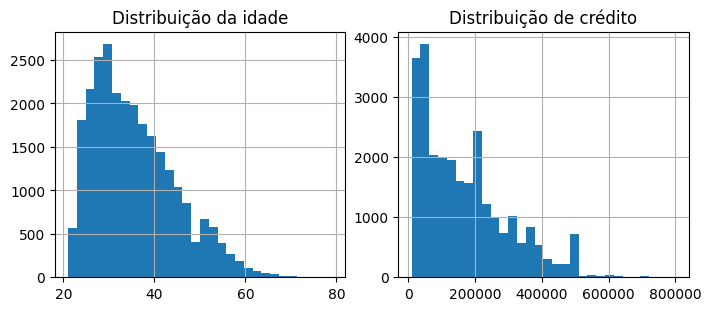

In [21]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(7, 3))

axes[0].hist(df_clean_1["AGE"], bins=30);
axes[0].set_title("Distribuição da idade");
axes[0].grid(True);

axes[1].hist(df_clean_1["LIMIT_BAL"], bins=30);
axes[1].set_title("Distribuição de crédito");
axes[1].grid(True);

In [22]:
df_clean_1[["LIMIT_BAL", "AGE"]].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


In [23]:
info_var["EDUCATION"]

'Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).'

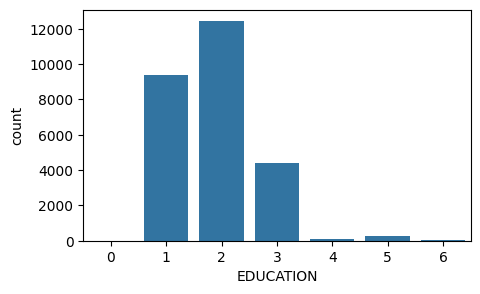

In [24]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_clean_1, x="EDUCATION");

##### De acordo com o dicionário de dados, não existem classificações para 0, 5 e 6.

##### Remoção dos valores não disponíveis*

*_OBS:_* _Ao remover dados antes do treinamento, pode acarretar em vazamento de dados (data leakage). Essa abordagem foi utilizada pelo autor, seguirei dessa forma durante este projeto._

In [25]:
df_clean_1["EDUCATION"] = df_clean_1["EDUCATION"].replace(to_replace=[0, 5, 6], value=4)

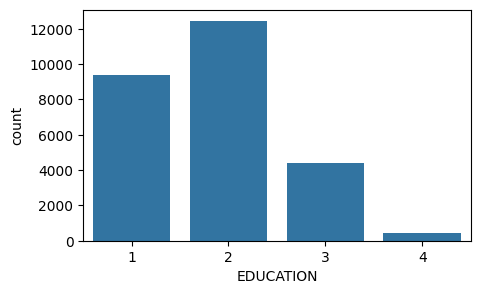

In [26]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_clean_1, x="EDUCATION");

In [27]:
info_var["MARRIAGE"]

'Marital status (1 = married; 2 = single; 3 = others).'

In [28]:
df_clean_1["MARRIAGE"].value_counts()

MARRIAGE
2    14158
1    12172
3      286
0       48
Name: count, dtype: int64

In [29]:
df_clean_1["EDUCATION"] = df_clean_1["EDUCATION"].replace(to_replace=[0, 5, 6], value=4)

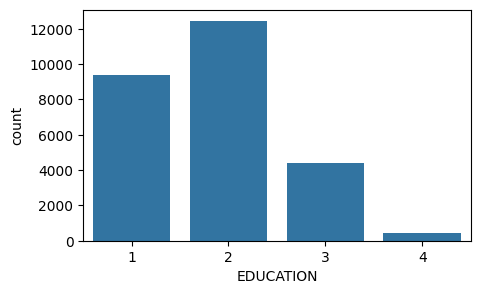

In [30]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_clean_1, x="EDUCATION");

In [31]:
df_clean_1["MARRIAGE"].value_counts()

MARRIAGE
2    14158
1    12172
3      286
0       48
Name: count, dtype: int64

In [32]:
info_var["MARRIAGE"]

'Marital status (1 = married; 2 = single; 3 = others).'

##### De acordo com o dicionário de dados, não existem classificações para 0

In [33]:
df_clean_1["MARRIAGE"] = df_clean_1["MARRIAGE"].replace(to_replace=0, value=3)

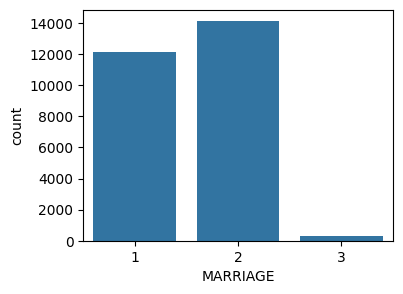

In [34]:
plt.figure(figsize=(4,3))
sns.countplot(data=df_clean_1, x="MARRIAGE");

##### Deep Dive: Categorical Features

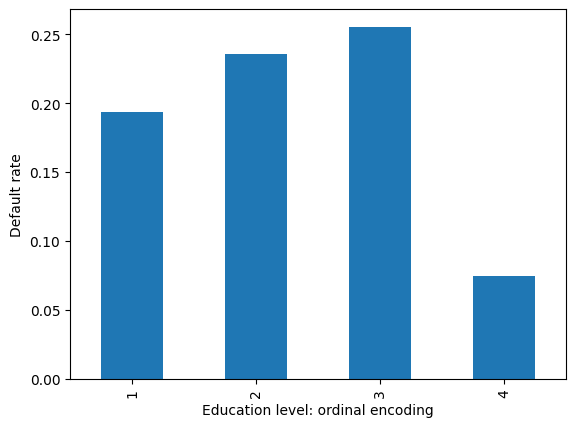

In [35]:
df_clean_1.groupby("EDUCATION").agg({"default payment next month":"mean"}).plot.bar(legend=False)
plt.ylabel('Default rate')
plt.xlabel('Education level: ordinal encoding');

###### Quando construímos um modelo de regressão logística uma das coisas que observamos é a linearidade da variável com o log da odds visando ter uma boa determinação dos coeficientes da regressão. Então, por isso nesse caso o autor sugere utilizar ou um modelo que capture as não linearidades como modelos de árvores ou utilizar outro tipo de encoding (OHE)

In [36]:
cat_mapping = {1: "graduate school",
                 2: "university",
                 3: "high school",
                 4: "others"}

df_clean_1["EDUCATION_CAT"] = df_clean_1["EDUCATION"].map(cat_mapping)

In [37]:
education_ohe = pd.get_dummies(df_clean_1["EDUCATION_CAT"]).astype(int)

education_ohe.head()

,graduate school,high school,others,university
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [38]:
df = pd.concat([df_clean_1, education_ohe], axis=1)\
        .drop(["EDUCATION", "EDUCATION_CAT"], axis=1)\
        .rename(columns={"default payment next month": "TARGET",
                         "graduate school": "EDUC_GRAD_SCHOOL",
                         "high school": "EDUC_HIGH_SCHOOL",
                         "others": "EDUC_OTHERS",
                         "university": "EDUC_UNIVERSITY"})

In [39]:
df.head()

,ID,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET,EDUC_GRAD_SCHOOL,EDUC_HIGH_SCHOOL,EDUC_OTHERS,EDUC_UNIVERSITY
0,798fc410-45c1,20000,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,0,1
2,85698822-43f5,90000,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,0,0,1
3,0737c11b-be42,50000,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0,0,1
4,3b7f77cc-dbc0,50000,1,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,0,1


##### Exploring the Financial History Features in the Dataset

In [40]:
pay_feats = ["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

df[pay_feats].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,-0.017777,-0.133363,-0.167679,-0.225023,-0.269764,-0.293579
std,1.126769,1.198640,1.199165,1.167897,1.131735,1.150229
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


#### Introduction to Scikit-Learn and Model Evaluation

##### Gerando dados sintéticos

In [44]:
np.random.seed(1)

# 1000 dados aleatórios com seed igual a "1", variando entre "0.0" e "10.0"
X = np.random.uniform(low=0.0, high=10.0, size=(1000,))

slope = 0.25
intercept = -1.25
# 1000 dados aleatórios de uma distribuição normal, com média igual a "0" e desvio padrão igual a "1"
noise = np.random.normal(loc=0.0, scale=1.0, size=(1000,))

y = slope * X + intercept + noise

###### Visualizando dados gerados

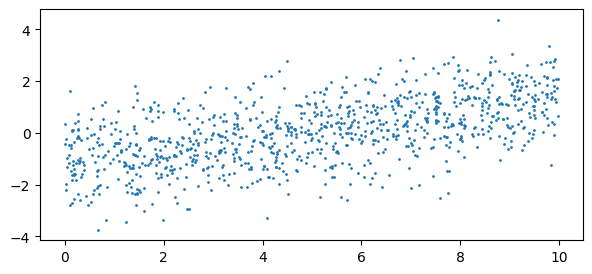

In [43]:
plt.figure(figsize=(7, 3))
plt.scatter(X, y, s=1);

##### Instanciando modelo estatístico

In [50]:
from sklearn.linear_model import LinearRegression

lr_test = LinearRegression()

##### Treinamento do modelo com dados sintéticos

In [54]:
# Transformando o X em uma matriz bidimensional, onde 1 representa o número de colunas e -1 indica que que o tamanho dessa dimensão
# deve ser calculado automaticamente para manter o número total de elementos constante

matriz_bidimensional_X = X.reshape(-1, 1)

lr_test.fit(matriz_bidimensional_X, y)

LinearRegression()

##### Realizando a previsão

In [56]:
y_pred = lr_test.predict(matriz_bidimensional_X)

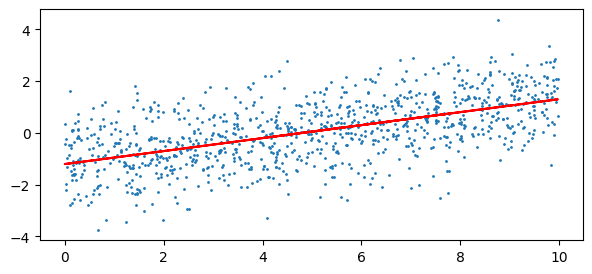

In [65]:
plt.figure(figsize=(7, 3))
plt.scatter(X, y, s=1)
plt.plot(X, y_pred, color='red');